<a href="https://colab.research.google.com/github/annaluizacaraciolo/DeepLearning2023/blob/main/Projeto_DangerousFarmInsects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from sklearn.model_selection import train_test_split
from google.colab import files

# Importando dataset

In [ ]:
! pip install -q kaggle
files.upload()

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download tarundalal/dangerous-insects-dataset

100% 446M/447M [00:29<00:00, 21.3MB/s]
100% 447M/447M [00:29<00:00, 16.1MB/s]


In [7]:
!unzip -q /content/dangerous-insects-dataset

# Armazenando o dataset

In [8]:
import pathlib
data = tf.keras.utils.image_dataset_from_directory("farm_insects", labels="inferred")
data_dir = pathlib.Path("farm_insects")

Found 1591 files belonging to 15 classes.


In [9]:
batch_size = 32
img_height = 224
img_width = 224

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1591 files belonging to 15 classes.
Using 1273 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1591 files belonging to 15 classes.
Using 318 files for validation.


A opção abaixo otimiza o treinamento ao deixar em memória os dados que forem utilizados na primeira epoch.
https://www.tensorflow.org/tutorials/images/classification?hl=pt-br#configure_the_dataset_for_performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Análise exploratória de dados

## Conhecendo o conjunto de dados

In [13]:
num_classes = len(data.class_names)
print("Number of classes:", num_classes)

Number of classes: 15


In [14]:
for species in data.class_names:
  class_name = species
  image_count = len(os.listdir('farm_insects/' + class_name))
  print(f"Class '{class_name}' has {image_count} images.")

Class 'Africanized Honey Bees (Killer Bees)' has 97 images.
Class 'Aphids' has 88 images.
Class 'Armyworms' has 96 images.
Class 'Brown Marmorated Stink Bugs' has 114 images.
Class 'Cabbage Loopers' has 104 images.
Class 'Citrus Canker' has 104 images.
Class 'Colorado Potato Beetles' has 112 images.
Class 'Corn Borers' has 115 images.
Class 'Corn Earworms' has 110 images.
Class 'Fall Armyworms' has 113 images.
Class 'Fruit Flies' has 101 images.
Class 'Spider Mites' has 119 images.
Class 'Thrips' has 109 images.
Class 'Tomato Hornworms' has 109 images.
Class 'Western Corn Rootworms' has 100 images.


A partir da análise de quantiade de imagens presentes nas amostras de cada classe, percebemos que o conjunto de dados trabalhado é bem distribuído.

## Visualizando o conjunto de dados

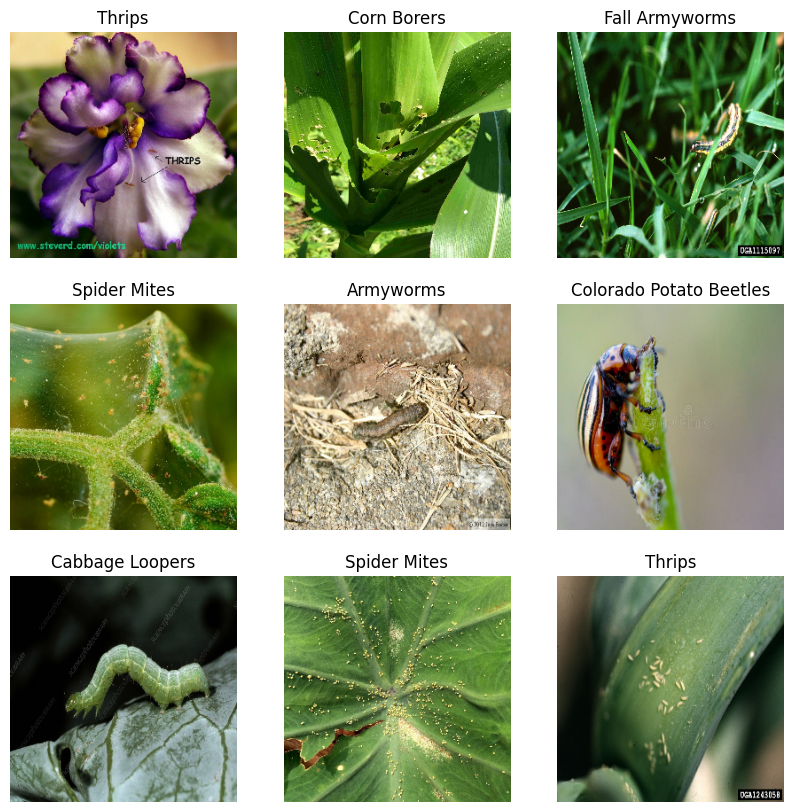

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")
plt.show()


## Dimensão das imagens

In [16]:
import tensorflow as tf
import pathlib

data_dir = pathlib.Path("farm_insects")
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=(224, 224))

# Get image dimensions
image_shapes = set()
for images, _ in data:
    for image in images:
        image_shapes.add(image.shape)

print("Different image shapes found in the dataset:")
print(image_shapes)

# Check if images have consistent dimensions
if len(image_shapes) == 1:
    print("All images have consistent dimensions.")
    image_height, image_width, num_channels = image_shapes.pop()
else:
    print("Images have varying dimensions.")
    # Decide on a common size for resizing, e.g., (height, width)
    common_image_size = (224, 224)  # You can change this to your preferred size
    image_height, image_width, num_channels = common_image_size


Found 1591 files belonging to 15 classes.
Different image shapes found in the dataset:
{TensorShape([224, 224, 3])}
All images have consistent dimensions.


## Data augmentaion

A técnica de data augmentation que foi experimentada está documentada abaixo. Entretanto, não foi utilizada para a continuidado dos experimentos pois os testes realizados com o conjunto de treinamento após a aplicação de data augmentation apresentou resultados muito inferiores com relação aos resultados obtidos com o conjunto de treino sem modificações.

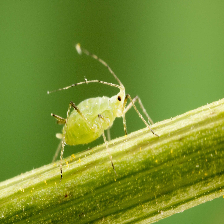

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = 'farm_insects/Aphids/Image_1.jpeg'
img = image.load_img(img_path, target_size=(224, 224, 3))
display(img)


In [ ]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

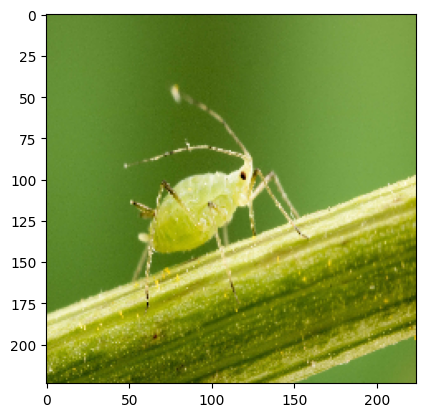

In [ ]:
result = rescale(img)
plt.imshow(result)

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [ ]:
# Add the image to a batch.
image = tf.expand_dims(result, 0)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

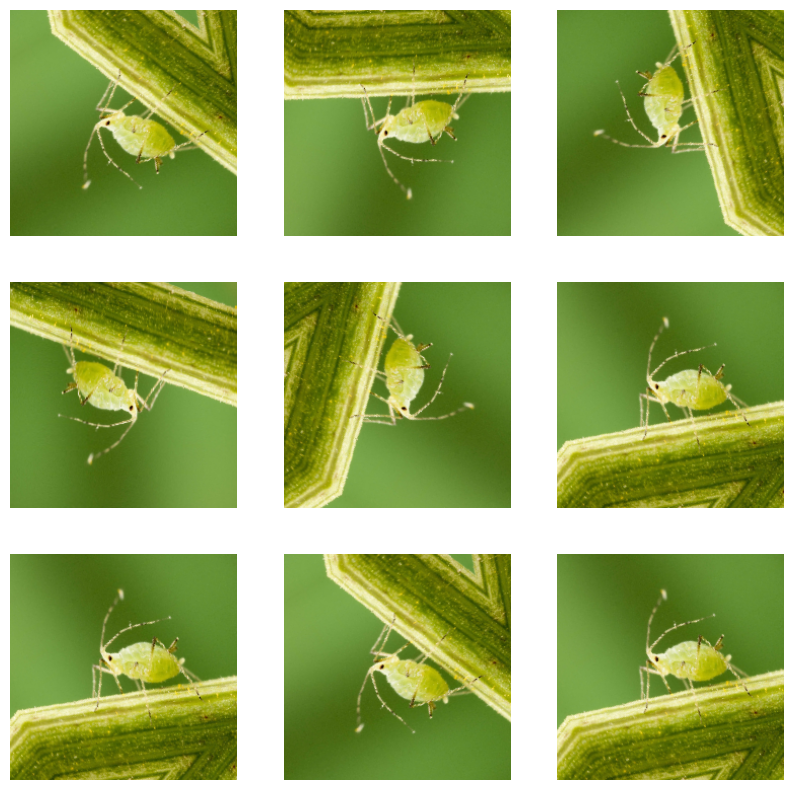

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Aplicando data augmentation em todo o dataset

In [ ]:
train_ds = train_ds.map(
  lambda x, y: (rescale(x, training=True), y))

In [ ]:
val_ds = val_ds.map(
  lambda x, y: (rescale(x, training=True), y))

In [ ]:
train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Treinamento
- Fazer o treinamento de uma rede VGG pré treinada no ImageNet (transfer learning)
- Fazer o treinamento de uma rede VGG com o dataset Dangerous Farm Insects
- Fazer o treinamento de uma MobileNet (pois é econômica de recursos) ou densenet

## Base model VGG 16 - Transfer learning

Aplicando o passo a passo da documentação do Keras [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow)

In [17]:
base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

58889256/58889256 [==============================] - 3s 0us/step


In [18]:
base_model.trainable = False

In [19]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with 15 neurons
outputs = keras.layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [20]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
history_vgg_tl = model.fit(train_ds, epochs=10)

Epoch 1/10
40/40 [==============================] - 34s 218ms/step - loss: 8.6008 - sparse_categorical_accuracy: 0.1115
Epoch 2/10
40/40 [==============================] - 5s 126ms/step - loss: 4.6132 - sparse_categorical_accuracy: 0.2985
Epoch 3/10
40/40 [==============================] - 5s 129ms/step - loss: 3.0810 - sparse_categorical_accuracy: 0.4430
Epoch 4/10
40/40 [==============================] - 5s 129ms/step - loss: 2.2712 - sparse_categorical_accuracy: 0.5334
Epoch 5/10
40/40 [==============================] - 5s 131ms/step - loss: 1.7511 - sparse_categorical_accuracy: 0.6017
Epoch 6/10
40/40 [==============================] - 5s 132ms/step - loss: 1.3752 - sparse_categorical_accuracy: 0.6496
Epoch 7/10
40/40 [==============================] - 5s 135ms/step - loss: 1.1027 - sparse_categorical_accuracy: 0.7054
Epoch 8/10
40/40 [==============================] - 6s 143ms/step - loss: 0.9372 - sparse_categorical_accuracy: 0.7361
Epoch 9/10
40/40 [=============================

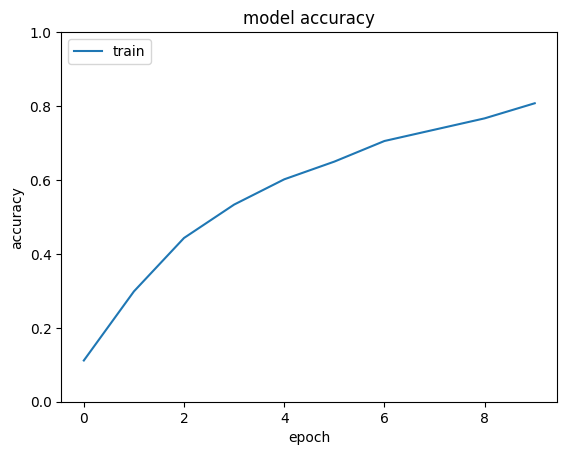

In [21]:
plt.plot(history_vgg_tl.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0, 1])
plt.legend(['train'], loc='upper left')
plt.show()

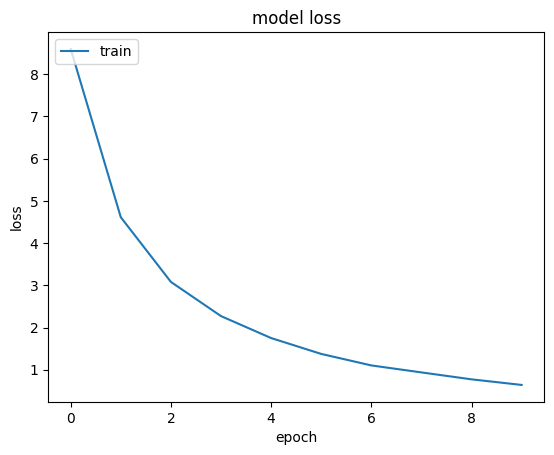

In [22]:
plt.plot(history_vgg_tl.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Fine tuning

In [23]:
base_model.trainable = True

In [24]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
history_fine_tuning_tl = model.fit(train_ds, epochs=15)

Epoch 1/15
40/40 [==============================] - 39s 610ms/step - loss: 0.7061 - sparse_categorical_accuracy: 0.7910
Epoch 2/15
40/40 [==============================] - 18s 442ms/step - loss: 0.2384 - sparse_categorical_accuracy: 0.9356
Epoch 3/15
40/40 [==============================] - 17s 432ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.9639
Epoch 4/15
40/40 [==============================] - 18s 439ms/step - loss: 0.1106 - sparse_categorical_accuracy: 0.9764
Epoch 5/15
40/40 [==============================] - 18s 443ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.9756
Epoch 6/15
40/40 [==============================] - 18s 444ms/step - loss: 0.0794 - sparse_categorical_accuracy: 0.9819
Epoch 7/15
40/40 [==============================] - 18s 441ms/step - loss: 0.0800 - sparse_categorical_accuracy: 0.9804
Epoch 8/15
40/40 [==============================] - 18s 439ms/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9819
Epoch 9/15
40/40 [======================

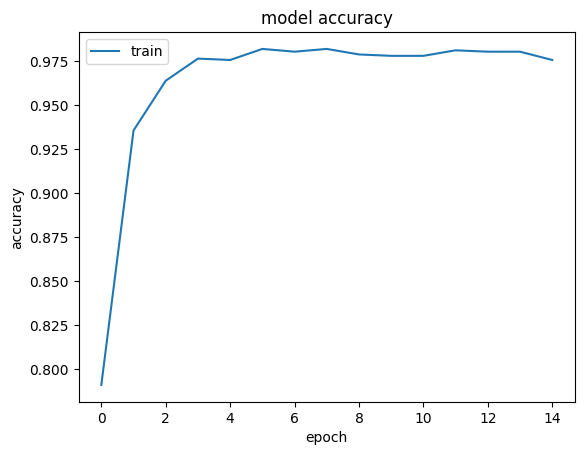

In [25]:
plt.plot(history_fine_tuning_tl.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

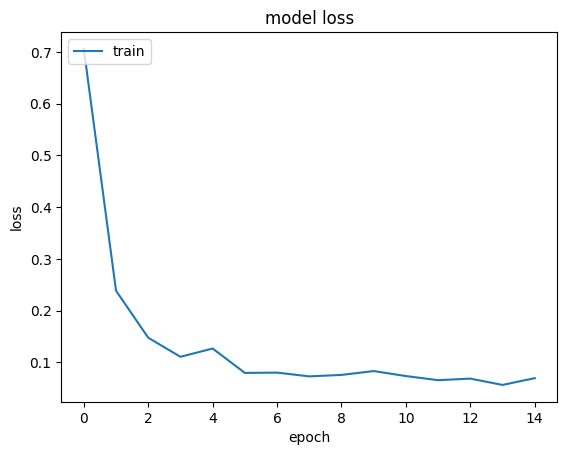

In [26]:
plt.plot(history_fine_tuning_tl.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Teste

In [33]:
vgg_predictions = model.evaluate(val_ds)

10/10 [==============================] - 1s 137ms/step - loss: 2.0028 - sparse_categorical_accuracy: 0.6384


In [34]:
pred=model.predict(val_ds, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

10/10 [==============================] - 1s 140ms/step


In [35]:
test_images, test_labels = next(iter(val_ds))

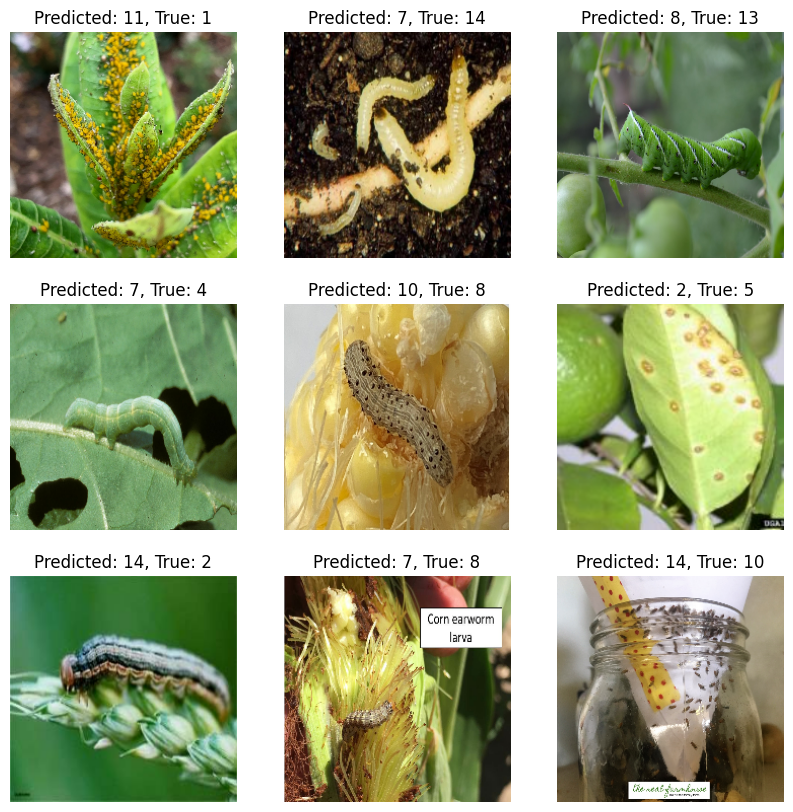

In [36]:
plt.figure(figsize=(10, 10))
for test_images, test_labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i].numpy().astype("uint8"))
        # Get the predicted class label
        predicted_label = predicted_class_indices[i]
        plt.title(f'Predicted: {predicted_label}, True: {test_labels[i]}')
        plt.axis("off")
plt.show()

## Rede VGG

A seguir, temos a implementação de uma rede VGG sem estar pré-treinada.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)

model_vgg = Sequential()

#BLOCOS
#2 camadas de convolução e 1 camada de pooling
model_vgg.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model_vgg.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model_vgg.add(MaxPooling2D((2, 2), strides=(2, 2)))

#Transformando em um vetor unidimensional
model_vgg.add(Flatten())

learning_rate = 0.001

# Crie o otimizador com a taxa de aprendizado especificada
optimizer = Adam(learning_rate=learning_rate)

#Fully connected layers
model_vgg.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.001)))
model_vgg.add(Dense(4096, activation='relu'))
model_vgg.add(Dense(15, activation='softmax'))  #número de classes
#utilização da função softmax para gerar probabilidades para cada classe

model_vgg.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_43 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_45 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [ ]:
epochs = 10
batch_size = 32

In [ ]:
history_vgg = model_vgg.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds
)

Epoch 1/10
40/40 [==============================] - 31s 567ms/step - loss: 195.4450 - accuracy: 0.0589 - val_loss: 5.6404 - val_accuracy: 0.0597
Epoch 2/10
40/40 [==============================] - 25s 566ms/step - loss: 5.2983 - accuracy: 0.0707 - val_loss: 5.0429 - val_accuracy: 0.0566
Epoch 3/10
40/40 [==============================] - 25s 572ms/step - loss: 5.0434 - accuracy: 0.0636 - val_loss: 4.8328 - val_accuracy: 0.0692
Epoch 4/10
40/40 [==============================] - 24s 544ms/step - loss: 4.7672 - accuracy: 0.0652 - val_loss: 4.7184 - val_accuracy: 0.0755
Epoch 5/10
40/40 [==============================] - 25s 565ms/step - loss: 4.6752 - accuracy: 0.0644 - val_loss: 4.6469 - val_accuracy: 0.0755
Epoch 6/10
40/40 [==============================] - 24s 546ms/step - loss: 4.6140 - accuracy: 0.0762 - val_loss: 4.5939 - val_accuracy: 0.0755
Epoch 7/10
40/40 [==============================] - 25s 555ms/step - loss: 4.5650 - accuracy: 0.0691 - val_loss: 4.5505 - val_accuracy: 0.07

A partir desses resultados, já percebemos alguns problemas: a acurácia de treinamento, em muitos casos, é menor do que a acurácia de validação. Além disso, os valores de acurácia estão muito baixos.

Tentamos resolver esse problema de várias formas: mudar o número de epochs, mudar o batch size, aplicar regularização e utilizar data augmentation. Porém, nenhum dos métodos utilizados resolveu.

In [ ]:
test_loss, test_accuracy = model_vgg.evaluate(val_ds)
print(f'Acurácia no conjunto de validação: {test_accuracy * 100:.2f}%')

10/10 [==============================] - 1s 122ms/step - loss: 2.7117 - accuracy: 0.0566
Acurácia no conjunto de validação: 5.66%


Dessa forma, resolvemos utilizar outra arquitetura: NiN.

## NiN

Na definição do modelo, utilizamos o mesmo optimizer e a mesma loss function que foram utilizadas no VGG.

A ideia dessa arquitetura é reduzir a complexidade diminunindo a quantidade de parâmetros necessários. É possível perceber a diferença no número de parâmetros entre as duas arquiteturas quando utilizamos a função model.summary().

Nesse contexto, a NiN adiciona não-linearidades locais.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

model_nin = Sequential()
model_nin.add(Conv2D(96, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=(224, 224, 3)))
model_nin.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model_nin.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
model_nin.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model_nin.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
model_nin.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model_nin.add(Flatten())
model_nin.add(Dense(512, activation='relu'))
model_nin.add(Dropout(0.5))
model_nin.add(Dense(512, activation='relu'))
model_nin.add(Dropout(0.5))
model_nin.add(Dense(15, activation='softmax'))

model_nin.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 96)      14208     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 384)       885120    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 384)      0

In [ ]:
epochs = 50
batch_size = 32
history_nin = model_nin.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds)

Epoch 1/50
40/40 [==============================] - 33s 231ms/step - loss: 27.8312 - accuracy: 0.0605 - val_loss: 2.7042 - val_accuracy: 0.0629
Epoch 2/50
40/40 [==============================] - 3s 73ms/step - loss: 2.6774 - accuracy: 0.1045 - val_loss: 2.6712 - val_accuracy: 0.0818
Epoch 3/50
40/40 [==============================] - 3s 71ms/step - loss: 2.6205 - accuracy: 0.1422 - val_loss: 2.6240 - val_accuracy: 0.1415
Epoch 4/50
40/40 [==============================] - 3s 71ms/step - loss: 2.5012 - accuracy: 0.1854 - val_loss: 2.5804 - val_accuracy: 0.1761
Epoch 5/50
40/40 [==============================] - 3s 71ms/step - loss: 2.3124 - accuracy: 0.2498 - val_loss: 2.5650 - val_accuracy: 0.1447
Epoch 6/50
40/40 [==============================] - 3s 73ms/step - loss: 2.0907 - accuracy: 0.3433 - val_loss: 2.4790 - val_accuracy: 0.2421
Epoch 7/50
40/40 [==============================] - 3s 72ms/step - loss: 1.7407 - accuracy: 0.4438 - val_loss: 2.7701 - val_accuracy: 0.2107
Epoch 8/50

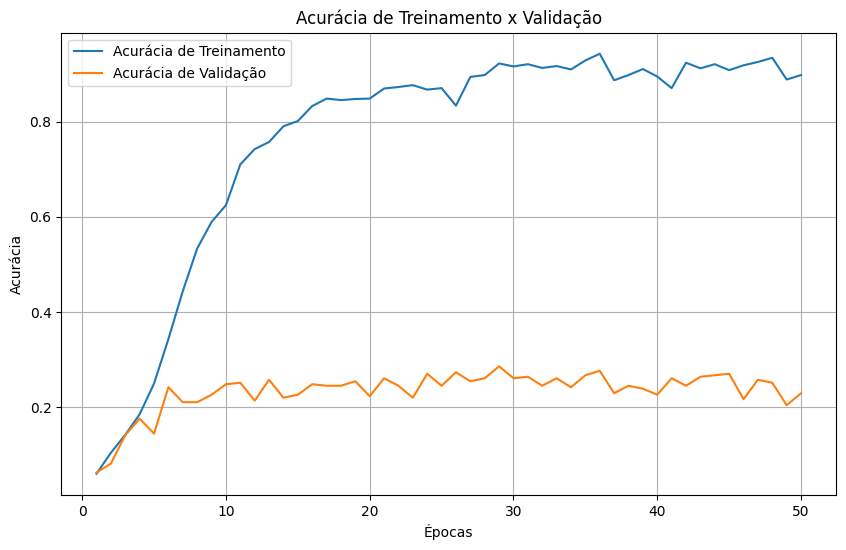

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracy, label='Acurácia de Treinamento')
plt.plot(range(1, epochs + 1), val_accuracy, label='Acurácia de Validação')
plt.title('Acurácia de Treinamento x Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = model_nin.evaluate(val_ds)
print(f'Acurácia no conjunto de validação: {test_accuracy * 100:.2f}%')

10/10 [==============================] - 0s 33ms/step - loss: 5.2299 - accuracy: 0.2296
Acurácia no conjunto de validação: 22.96%


Percebemos que os resultados são consistentes (acurácia de treinamento >= acurácia de validação) e os valores de acurácia aumentaram, apesar de ainda estarem baixos.

### Testes - NiN

Fruit flies

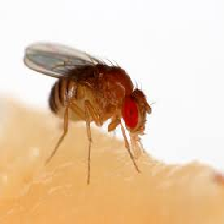

1/1 [==============================] - 0s 66ms/step
[[9.5023960e-04 1.3353433e-03 5.0601885e-03 1.6956606e-04 2.6146197e-04
  1.6729371e-04 1.1601410e-02 1.9501770e-04 2.9695956e-03 6.6184779e-03
  9.6496594e-01 9.7676901e-05 4.8322137e-03 4.7081432e-04 3.0466201e-04]]


In [ ]:
img_path = '/content/transferir.jfif'
img = image.load_img(img_path, target_size=(224, 224))

display(img)

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

predictions = model_nin.predict(img_array)

print(predictions)

In [ ]:
class_idx = np.argmax(predictions[0])
class_label = data.class_names[class_idx]
print(class_label)
for i, probabilidade in enumerate(predictions[0]):
    print(f'Classe {data.class_names[i]}: {probabilidade:.2f}')

Classe Africanized Honey Bees (Killer Bees): 0.00
Classe Aphids: 0.00
Classe Armyworms: 0.01
Classe Brown Marmorated Stink Bugs: 0.00
Classe Cabbage Loopers: 0.00
Classe Citrus Canker: 0.00
Classe Colorado Potato Beetles: 0.01
Classe Corn Borers: 0.00
Classe Corn Earworms: 0.00
Classe Fall Armyworms: 0.01
Classe Fruit Flies: 0.96
Classe Spider Mites: 0.00
Classe Thrips: 0.00
Classe Tomato Hornworms: 0.00
Classe Western Corn Rootworms: 0.00


Tomato Hornworms

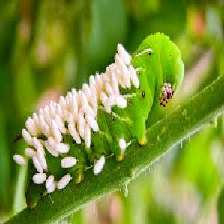

1/1 [==============================] - 0s 21ms/step
[[0.00293423 0.00917748 0.03768035 0.10636777 0.00709223 0.0345383
  0.05505718 0.1435357  0.01050771 0.09199584 0.03758661 0.00895757
  0.01857136 0.43470037 0.00129724]]


In [ ]:
img_path = '/content/tomato_hornworms.jfif'
img = image.load_img(img_path, target_size=(224, 224))

display(img)

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

predictions = model_nin.predict(img_array)

print(predictions)

In [ ]:
class_idx = np.argmax(predictions[0])
class_label = data.class_names[class_idx]
print("CLASSIFICAÇÃO: " + class_label)
print("\n")
for i, probabilidade in enumerate(predictions[0]):
    print(f'Classe {data.class_names[i]}: {probabilidade:.2f}')

CLASSIFICAÇÃO: Tomato Hornworms


Classe Africanized Honey Bees (Killer Bees): 0.00
Classe Aphids: 0.01
Classe Armyworms: 0.04
Classe Brown Marmorated Stink Bugs: 0.11
Classe Cabbage Loopers: 0.01
Classe Citrus Canker: 0.03
Classe Colorado Potato Beetles: 0.06
Classe Corn Borers: 0.14
Classe Corn Earworms: 0.01
Classe Fall Armyworms: 0.09
Classe Fruit Flies: 0.04
Classe Spider Mites: 0.01
Classe Thrips: 0.02
Classe Tomato Hornworms: 0.43
Classe Western Corn Rootworms: 0.00


Colorado Potato Beetles

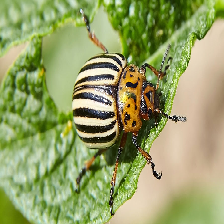

1/1 [==============================] - 0s 44ms/step
[[2.6790662e-05 6.6032144e-04 2.7657121e-05 1.9228943e-02 4.3997442e-04
  2.2183431e-06 9.3033254e-05 7.3225362e-07 3.7853360e-06 3.2605574e-04
  6.6535956e-01 7.2081042e-03 2.3099503e-01 7.5591311e-02 3.6485475e-05]]


In [ ]:
img_path = '/content/Colorado-beetle_AdobeStock_215049989_c-mikeophoto-Adobe-Stock.jpg'
img = image.load_img(img_path, target_size=(224, 224))

display(img)

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

predictions = model_nin.predict(img_array)

print(predictions)

In [ ]:
class_idx = np.argmax(predictions[0])
class_label = data.class_names[class_idx]
print("CLASSIFICAÇÃO: " + class_label)
print("\n")
for i, probabilidade in enumerate(predictions[0]):
    print(f'Classe {data.class_names[i]}: {probabilidade:.2f}')

CLASSIFICAÇÃO: Fruit Flies


Classe Africanized Honey Bees (Killer Bees): 0.00
Classe Aphids: 0.00
Classe Armyworms: 0.00
Classe Brown Marmorated Stink Bugs: 0.02
Classe Cabbage Loopers: 0.00
Classe Citrus Canker: 0.00
Classe Colorado Potato Beetles: 0.00
Classe Corn Borers: 0.00
Classe Corn Earworms: 0.00
Classe Fall Armyworms: 0.00
Classe Fruit Flies: 0.67
Classe Spider Mites: 0.01
Classe Thrips: 0.23
Classe Tomato Hornworms: 0.08
Classe Western Corn Rootworms: 0.00


Africanized Honey Bees (Killer Bees)

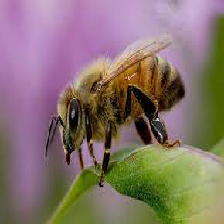

1/1 [==============================] - 0s 27ms/step
[[9.5977873e-01 3.6562860e-04 1.2077027e-04 6.6606053e-03 4.4571300e-04
  3.5588466e-05 1.8419821e-02 3.6919312e-06 1.1544471e-06 6.4097185e-05
  9.4771842e-03 1.4352181e-04 3.5520617e-04 4.1187666e-03 9.4867873e-06]]


In [ ]:
img_path = '/content/bees.jfif'
img = image.load_img(img_path, target_size=(224, 224))

display(img)

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

predictions = model_nin.predict(img_array)

print(predictions)

In [ ]:
class_idx = np.argmax(predictions[0])
class_label = data.class_names[class_idx]
print("CLASSIFICAÇÃO: " + class_label)
print("\n")
for i, probabilidade in enumerate(predictions[0]):
    print(f'Classe {data.class_names[i]}: {probabilidade:.2f}')

CLASSIFICAÇÃO: Africanized Honey Bees (Killer Bees)


Classe Africanized Honey Bees (Killer Bees): 0.96
Classe Aphids: 0.00
Classe Armyworms: 0.00
Classe Brown Marmorated Stink Bugs: 0.01
Classe Cabbage Loopers: 0.00
Classe Citrus Canker: 0.00
Classe Colorado Potato Beetles: 0.02
Classe Corn Borers: 0.00
Classe Corn Earworms: 0.00
Classe Fall Armyworms: 0.00
Classe Fruit Flies: 0.01
Classe Spider Mites: 0.00
Classe Thrips: 0.00
Classe Tomato Hornworms: 0.00
Classe Western Corn Rootworms: 0.00
